In [35]:
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import cv2
from scipy.interpolate import interpn
from tqdm.auto import tqdm

In [41]:
def plot_2fig(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(14, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_2fig_difference(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig1[:, :, :-1]-fig2, cmap='gray')
    plt.title('Difference')
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_3fig(fig1, fig2, fig3, name=None, t1=None, t2=None, t3=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(t1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(t2)
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig3, cmap='gray')
    plt.title(t3)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

In [3]:
def normalize(img):
    return (img - img.min())/(img.max() - img.min())

In [4]:
museum_ambient = skimage.io.imread('data/museum/museum_ambient.png')
museum_flash = skimage.io.imread('data/museum/museum_flash.png')
print(museum_ambient.shape, museum_flash.shape)
print(museum_ambient.min(), museum_ambient.max())

Aimg = normalize(museum_ambient)
Flash_img = normalize(museum_flash)
print(Aimg.min(), Aimg.max())
print(Flash_img.min(), Flash_img.max())

(638, 905, 4) (638, 905, 4)
0 255
0.0 1.0
0.0 1.0


In [62]:
def gradient(img):
    H, W = img.shape
    # print(img.shape)
    padded_Ix = np.concatenate((img, np.zeros((H, 1))), axis=1) 
    padded_Iy = np.concatenate((img, np.zeros((1, W))), axis=0) 
    Ix = np.diff(padded_Ix, 1, axis=1)
    Iy = np.diff(padded_Iy, 1, axis=0)
    return np.stack((Ix, Iy), axis=2)

In [61]:
def divergence(input):
    Ix = input[:, :, 0]
    Iy = input[:, :, 1]
    H, W = Ix.shape
    # print(H, W)
    padded_Ixx = np.concatenate((np.zeros((H, 1)), Ix), axis=1) 
    padded_Iyy = np.concatenate((np.zeros((1, W)), Iy), axis=0) 
    Ixx = np.diff(padded_Ixx, 1, axis=1)
    Iyy = np.diff(padded_Iyy, 1, axis=0)
    return Ixx + Iyy

In [7]:
def set_boundary(I_set, I_or):
    I_set[:, 0] = I_or[:, 0]
    I_set[0, :] = I_or[0, :]
    I_set[:, -1] = I_or[:, -1]
    I_set[-1, :] = I_or[-1, :]
    return I_set

In [8]:
def laplacian(input):
    K = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
#     print(input.shape, K.shape)
    return scipy.signal.convolve2d(input, K, mode='same')

In [63]:
# Implementing for single channel
def q2_1(I):
    H, W = I.shape
    print(H, W)
    grad = gradient(I)
    div = divergence(grad)

    D = laplacian(I)
    
    B = Mask_B(H, W)
    
    Is_init = np.zeros((H, W))
    Is_boundary = np.ones((H, W))
    Is_boundary = set_boundary(Is_boundary, I)
    return D, B, Is_init, Is_boundary

# plt.imshow(Is_boundary, cmap='gray')
# plt.axis('off')

In [10]:
def dot_prod(arr1, arr2):
    arr1 = arr1.flatten()
    arr2 = arr2.flatten()
    return np.dot(arr1, arr2)

In [39]:
def Mask_B(H, W):
    # Define mask B
    B = np.ones((H, W))
    B[:, 0] = 0.0
    B[0, :] = 0.0
    B[-1, :] = 0.0
    B[:, -1] = 0.0
    return B

In [135]:
def poisson_solver(B, D, Is_init, Is_boundary):
    '''
    B = Mask 
    D = Divergence of the gradient field we want to integrate 
    '''
    eta = 0.005
    N = 1400
    I_star = np.multiply(B, Is_init) + np.multiply(1.0-B, Is_boundary)
    r = np.multiply(B, (D - laplacian(I_star)))
    d = r
    delta_new = dot_prod(r, r)
    n = 0
    pbar = tqdm(total=N)

    while np.sqrt(dot_prod(r, r)) > eta and n < N:
        q = laplacian(d)
        eta = delta_new / dot_prod(d, q)
        I_star = I_star + np.multiply(B, (eta*d))
        r = np.multiply(B, (r - eta*q))
        delta_old = delta_new
        delta_new = dot_prod(r, r)
        beta = delta_new / delta_old
        d = r + beta*d
        n = n+1    
        pbar.update(10)
        #if n % 200 == 0:
        #    plot_2fig_difference(I, I_star, name='Extra_2_1_{}.png'.format(str(n)), title1='Original', title2='Re-integrated')
    pbar.close()
    return I_star

638 905
(638, 905)
638 905
(638, 905) (638, 905) (638, 905) (638, 905)
0.0 1.0 -0.5137254901960787 0.5098039215686275 0.0 0.0 0.0 1.0


880it [00:02, 355.02it/s]                                                       

KeyboardInterrupt: 

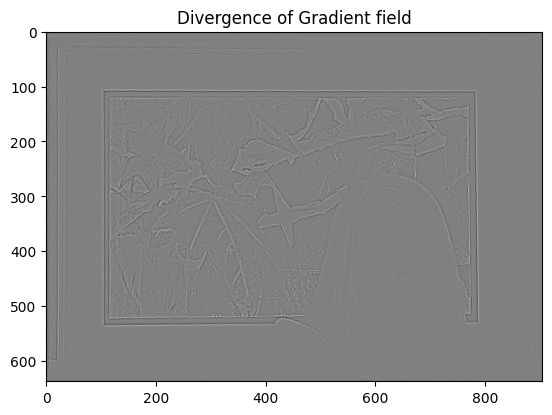

In [30]:
res = []
for i in range(3):
    I_channel = Aimg[:, :, i]
    lap, B, Is_init, Is_boundary = q2_1(I_channel)
    plt.imshow(lap, cmap='gray')
    plt.title('Divergence of Gradient field')
    plt.savefig('q_21_helper.png')
    print(B.shape, lap.shape, Is_boundary.shape, Is_init.shape)
    print(B.min(), B.max(), lap.min(), lap.max(), Is_init.min(), Is_init.max(), Is_boundary.min(), Is_boundary.max())
    I_star_channel = poisson_solver(B, lap, Is_init, Is_boundary)
    res.append(I_star_channel)
Output = np.stack(res, axis=2)
plot_2fig(Aimg, Output, name='final_q21.png', title1='Original Image', title2='Re-Integrated')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


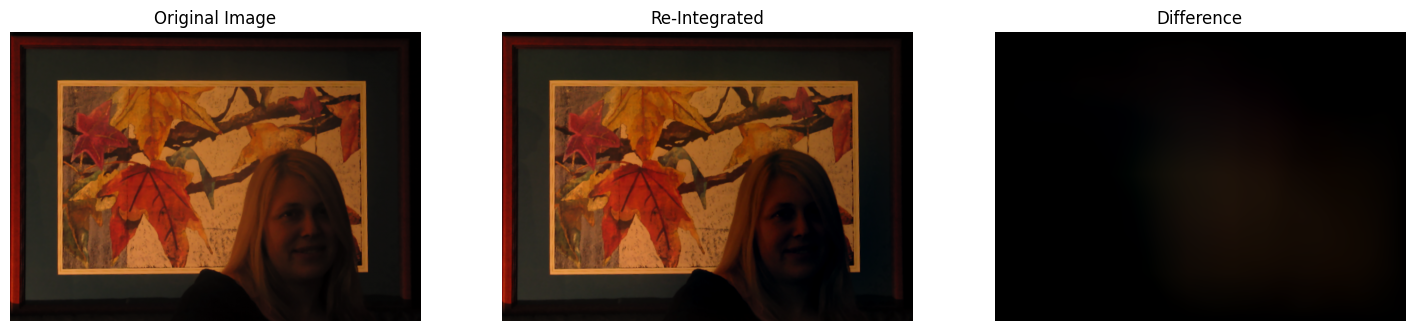

In [26]:
plot_2fig_difference(Aimg, Output, name='final_q21_diff.png', title1='Original Image', title2='Re-Integrated')

Able to perfectly re-integrate back the divergence of the gradient, in the RGB image!
### Q 2.2, fusing Ambient-Flash pair gradient field

638 905
(638, 905)
(638, 905)
(638, 905, 2) (638, 905, 2)


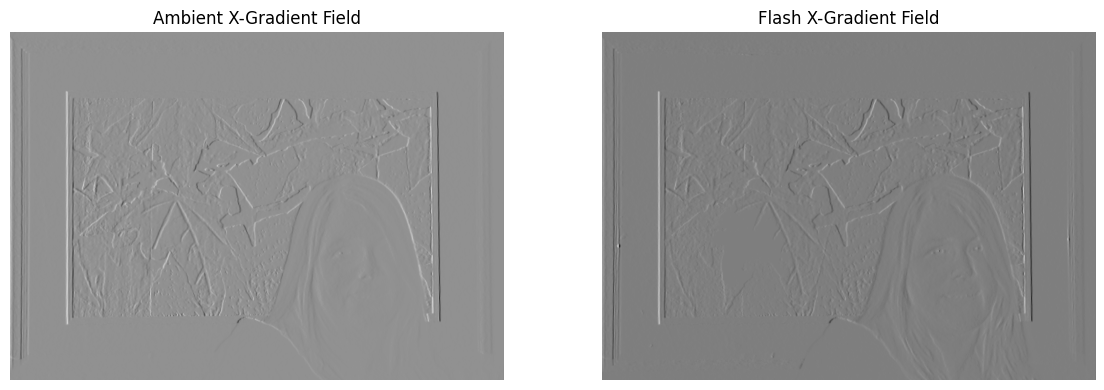

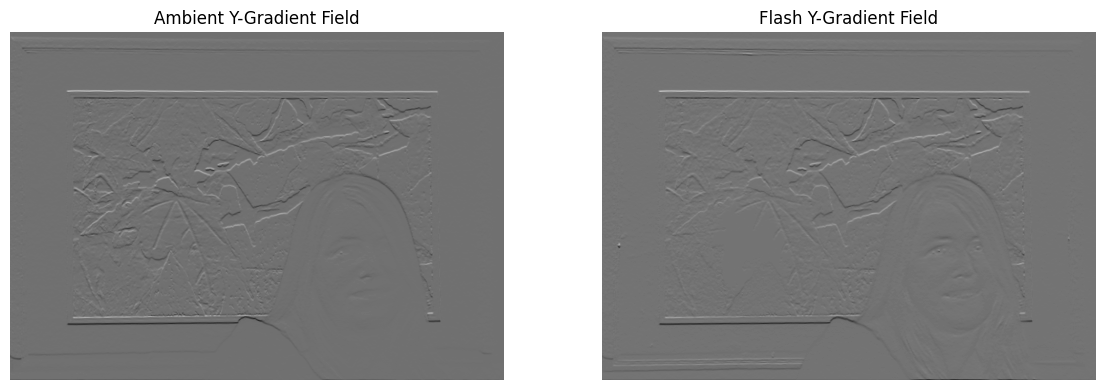

In [27]:
# fusing a single channel of A and F
H, W = Aimg[:, :, 0].shape
print(H, W)

A = Aimg[:, :, 0]
F = Flash_img[:, :, 0]
Agrad = gradient(A)
Fgrad = gradient(F)
print(Agrad.shape, Fgrad.shape)
# plot_2fig(Agrad[:, : , 0], Fgrad[:, :, 0], name='q22_A_F_DelX.png', title1='Ambient X-Gradient Field', title2='Flash X-Gradient Field')
# plot_2fig(Agrad[:, : , 1], Fgrad[:, :, 1], name='q22_A_F_DelY.png', title1='Ambient Y-Gradient Field', title2='Flash Y-Gradient Field')

In [107]:
def flash_gradient_fusion(A, F, sigma=40, tau_s=0.9):
    '''
    Pass Flash and Ambient image channel for gradient coherence and projection 
    '''
    H, W = A.shape
    Agrad = gradient(A)
    Fgrad = gradient(F)
    # STEP 1. MASK
    A_gX = Agrad[:, : , 0]
    A_gY = Agrad[:, : , 1]
    F_gX = Fgrad[:, : , 0]
    F_gY = Fgrad[:, : , 1]

    numerator = np.multiply(F_gX, A_gX) + np.multiply(F_gY, A_gY)
    t1 = np.sqrt(np.square(F_gX) + np.square(F_gY))
    t2 = np.sqrt(np.square(A_gX) + np.square(A_gY))
    denom = np.multiply(t1, t2)
    M = np.abs(numerator) / (denom + 1e-8)

    # STEP 2. saturation weight map
    w_s = np.tanh(sigma * (F - tau_s)) 
    # print(w_s.shape, w_s.min(), w_s.max())

    w_s = normalize(w_s)
    # print(w_s.min(), w_s.max())

    # STEP 3. new gradient field
    Fused_gX = (w_s * A_gX) + (1 - w_s)*(np.multiply(M, F_gX) + np.multiply((1 - M), A_gX))
    Fused_gY = (w_s * A_gY) + (1 - w_s)*(np.multiply(M, F_gY) + np.multiply((1 - M), A_gY))

    Fused_g = np.stack((Fused_gX, Fused_gY), axis=2)
    # print(f'shape of fused image gradient: {Fused_g.shape}')
    Fused_div = divergence(Fused_g)
    # print(f'shape of fused divergence: {Fused_div.shape}')
    
    return Fused_g, Fused_div

Different $\sigma, \tau_s$


In [109]:
A = Aimg[:, :, 0]
F = Flash_img[:, :, 0]
Agrad = gradient(A)
Fgrad = gradient(F)
# print(Agrad.shape, Fgrad.shape)

Fused_g, Fused_div = flash_gradient_fusion(A, F)

# plot_3fig(Agrad[:, : , 0], Fgrad[:, :, 0], Fused_g[:, :, 0], name='q22_3_reqX.png', t1='Ambient X-Grad Field', t2='Flash X-Grad Field', t3='Fused X, sigma=80, tau_s=0.9')
# plot_3fig(Agrad[:, : , 1], Fgrad[:, :, 1], Fused_g[:, :, 1], name='q22_3_reqY.png', t1='Ambient X-Grad Field', t2='Flash X-Grad Field', t3='Fused X, sigma=80, tau_s=0.9')

In [129]:
# get complete fusion RGB image
def gradient_fuse(A_rgb, F_rgb, use_boundary):
    res = []
    for i in range(3):
        A = A_rgb[:, :, i]
        F = F_rgb[:, :, i]
        H, W = A.shape
        
        Fused_g, Fused_div = flash_gradient_fusion(A, F, tau_s=0.55) # selected!!!
        B = Mask_B(H, W)
        Is_init = np.zeros((H, W))
        Is_boundary = np.ones((H, W))
    
        # Use use_boundary image as boundary conditions
        Is_boundary = set_boundary(Is_boundary, use_boundary[:, :, i]) # pass corres channel for setting boundary
        
        # sanity check
        print(Fused_div.min(), Fused_div.max(), Is_init.min(), Is_init.max(), Is_boundary.min(), Is_boundary.max())
    
        I_star_channel = poisson_solver(B, Fused_div, Is_init, Is_boundary)
        res.append(I_star_channel)
        
    return np.stack(res, axis=2)

-0.5137046899787133 0.5928550248121638 0.0 0.0 0.0 1.0


10000it [00:23, 428.12it/s]                                                     


-0.48559076632530146 0.46622676439982225 0.0 0.0 0.0 1.0


10000it [00:27, 358.53it/s]                                                     


-0.385423354539569 0.3715177017488028 0.0 0.0 0.0 1.0


10000it [00:29, 334.41it/s]                                                     
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


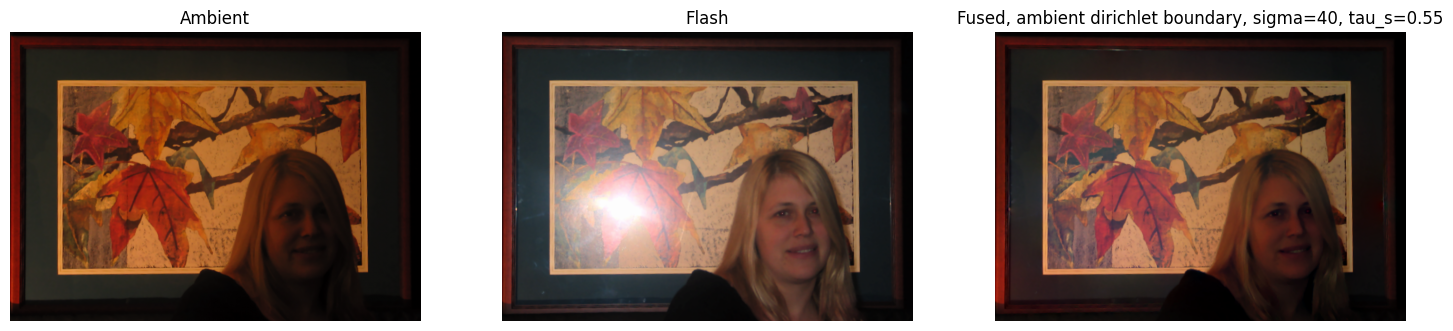

In [130]:
# boundary = Ambient 
ambient_boundary = gradient_fuse(Aimg, Flash_img, Aimg)
plot_3fig(Aimg[:, :, :-1], Flash_img[:, :, :-1], ambient_boundary, name='q22_tau1e55_fused_ambient.png', t1='Ambient', t2='Flash', t3='Fused, ambient dirichlet boundary, sigma=40, tau_s=0.55')


In [102]:
# plt.imshow(ambient_boundary - Aimg[:, :, :-1], cmap='gray')
# plt.savefig('q22_difference_ambient_fused.png')

-0.5137046899787133 0.5928550248121638 0.0 0.0 0.007905138339920948 1.0


10000it [00:26, 375.49it/s]                                                     


-0.48559076632530146 0.46622676439982225 0.0 0.0 0.007905138339920948 1.0


10000it [00:30, 328.28it/s]                                                     


-0.385423354539569 0.3715177017488028 0.0 0.0 0.003952569169960474 1.0


10000it [00:31, 313.72it/s]                                                     
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


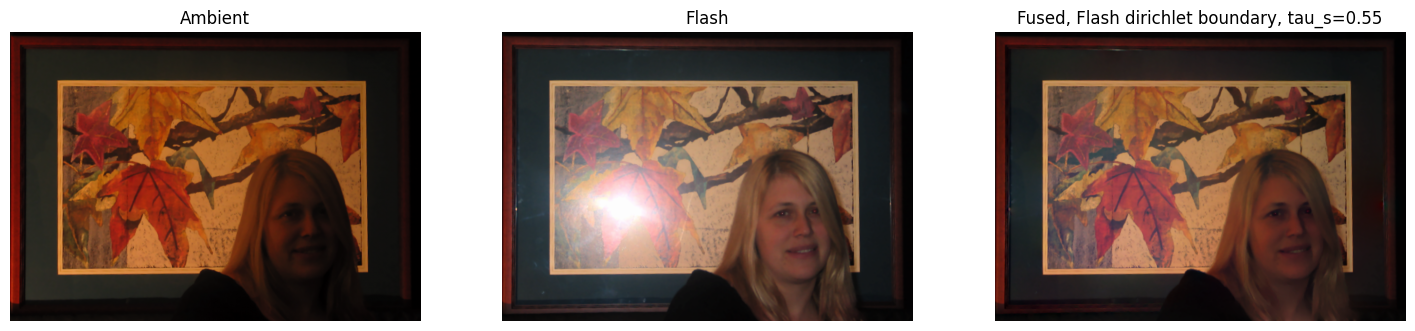

-0.5137046899787133 0.5928550248121638 0.0 0.0 0.003952569169960474 1.0


10000it [00:30, 332.02it/s]                                                     


-0.48559076632530146 0.46622676439982225 0.0 0.0 0.003952569169960474 1.0


10000it [00:35, 280.91it/s]                                                     


-0.385423354539569 0.3715177017488028 0.0 0.0 0.001976284584980237 1.0


10000it [00:33, 301.39it/s]                                                     
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


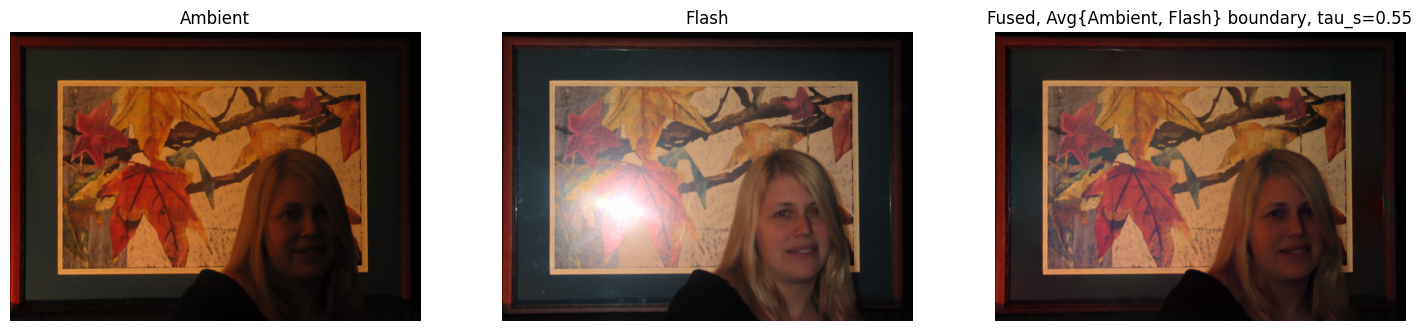

In [131]:
# boundary = Flash  
flash_boundary = gradient_fuse(Aimg, Flash_img, Flash_img)
plot_3fig(Aimg[:, :, :-1], Flash_img[:, :, :-1], flash_boundary, name='q22_fused_flash.png', t1='Ambient', t2='Flash', t3='Fused, Flash dirichlet boundary, tau_s=0.55')

AFAvg_boundary = gradient_fuse(Aimg, Flash_img, (Flash_img+Aimg)/2)
plot_3fig(Aimg[:, :, :-1], Flash_img[:, :, :-1], AFAvg_boundary, name='q22_fused_averageboundary.png', t1='Ambient', t2='Flash', t3='Fused, Avg{Ambient, Flash} boundary, tau_s=0.55')


(4000, 6000, 3) (4000, 6000, 3)
0 255
0.0 1.0
0.0 1.0


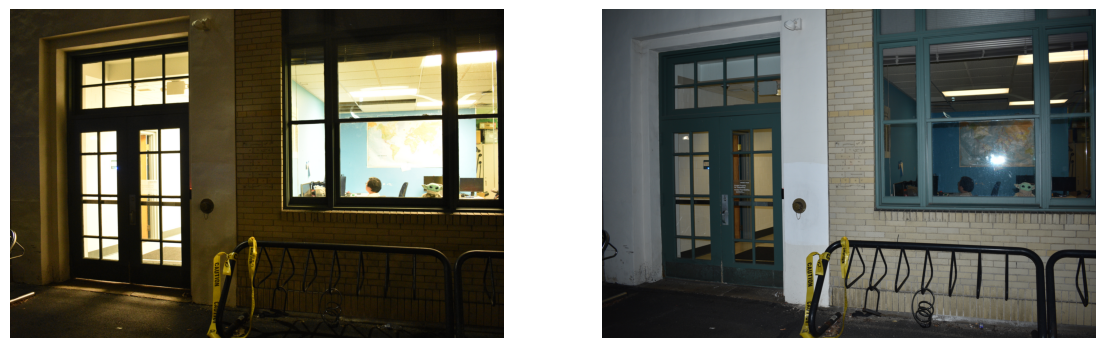

In [136]:
q2_ambient = skimage.io.imread('data/Mine/DSC_0172.JPG')
q2_flash = skimage.io.imread('data/Mine/DSC_0171.JPG')
print(q2_ambient.shape, q2_flash.shape)
print(q2_ambient.min(), q2_ambient.max())

Aimg = normalize(q2_ambient)
Flash_img = normalize(q2_flash)
print(Aimg.min(), Aimg.max())
print(Flash_img.min(), Flash_img.max())
plot_2fig(Aimg, Flash_img)

In [137]:
AFAvg_boundary = gradient_fuse(Aimg, Flash_img, (Flash_img+Aimg)/2)

-1.3301610625270035 0.959041110255916 0.0 0.0 0.01764705882352941 1.0



 69%|███████████████████████████▍            | 960/1400 [03:45<01:39,  4.43it/s]


100%|███████████████████████████████████████| 1400/1400 [05:28<00:00,  4.06it/s]
1410it [05:31,  3.89it/s]                                                       
1420it [05:34,  4.06it/s]
1430it [05:36,  4.16it/s]
1440it [05:38,  4.21it/s]
1450it [05:40,  4.23it/s]
1460it [05:43,  4.27it/s]
1470it [05:45,  4.35it/s]
1480it [05:47,  4.41it/s]
1490it [05:49,  4.40it/s]
1500it [05:52,  4.38it/s]
1510it [05:54,  4.37it/s]
1520it [05:56,  4.41it/s]
1530it [05:58,  4.44it/s]
1540it [06:01,  4.44it/s]
1550it [06:03,  4.31it/s]
1560it [06:06,  4.28it/s]
1570it [06:08,  4.24it/s]
1580it [06:10,  4.22it/s]
1590it [06:13,  4.27it/s]
1600it [06:15,  4.20it/s]
1610it [06:17,  4.24it/s]
1620it [06:20,  4.29it/s]
1630it [06:22,  4.34it/s]
1640it [06:24,  4.33it/s]
1650it [06:26,  4.35it/s]
1660it [06:29,  4.42it/s]
1670it [06:31,  4.44it/s]
1680it [06:33,  4.42it/s]
1690it [06:36,  4.38it/s]
1700it [06:38,  4.40it/s]
1710it [06:40,  4.42it/s]
1720it [06:42,  4.43it/s]
1730it [06:45,  4.41it/s]
1740it

2940it [11:23,  4.32it/s]
2950it [11:25,  4.32it/s]
2960it [11:28,  4.31it/s]
2970it [11:30,  4.29it/s]
2980it [11:32,  4.33it/s]
2990it [11:35,  4.31it/s]
3000it [11:37,  4.34it/s]
3010it [11:39,  4.32it/s]
3020it [11:41,  4.35it/s]
3030it [11:44,  4.34it/s]
3040it [11:47,  3.79it/s]
3050it [11:49,  3.98it/s]
3060it [11:54,  3.26it/s]
3070it [11:58,  3.01it/s]
3080it [12:00,  3.27it/s]
3090it [12:03,  3.47it/s]
3100it [12:05,  3.62it/s]
3110it [12:08,  3.74it/s]
3120it [12:10,  3.82it/s]
3130it [12:12,  3.90it/s]
3140it [12:15,  4.05it/s]
3150it [12:17,  4.16it/s]
3160it [12:19,  4.26it/s]
3170it [12:21,  4.39it/s]
3180it [12:23,  4.45it/s]
3190it [12:26,  4.51it/s]
3200it [12:28,  4.48it/s]
3210it [12:30,  4.47it/s]
3220it [12:32,  4.51it/s]
3230it [12:35,  4.48it/s]
3240it [12:37,  4.47it/s]
3250it [12:39,  4.54it/s]
3260it [12:41,  4.55it/s]
3270it [12:43,  4.58it/s]
3280it [12:45,  4.61it/s]
3290it [12:48,  4.62it/s]
3300it [12:50,  4.62it/s]
3310it [12:52,  4.63it/s]
3320it [12:5

5760it [22:15,  4.54it/s]
5770it [22:17,  4.54it/s]
5780it [22:19,  4.56it/s]
5790it [22:22,  4.56it/s]
5800it [22:24,  4.54it/s]
5810it [22:26,  4.52it/s]
5820it [22:28,  4.53it/s]
5830it [22:30,  4.54it/s]
5840it [22:33,  4.54it/s]
5850it [22:35,  4.55it/s]
5860it [22:37,  4.56it/s]
5870it [22:39,  4.55it/s]
5880it [22:41,  4.55it/s]
5890it [22:44,  4.51it/s]
5900it [22:46,  4.52it/s]
5910it [22:48,  4.55it/s]
5920it [22:50,  4.55it/s]
5930it [22:52,  4.57it/s]
5940it [22:55,  4.55it/s]
5950it [22:57,  4.56it/s]
5960it [22:59,  4.57it/s]
5970it [23:01,  4.58it/s]
5980it [23:03,  4.57it/s]
5990it [23:06,  4.56it/s]
6000it [23:08,  4.58it/s]
6010it [23:10,  4.58it/s]
6020it [23:12,  4.58it/s]
6030it [23:14,  4.57it/s]
6040it [23:17,  4.56it/s]
6050it [23:19,  4.56it/s]
6060it [23:21,  4.56it/s]
6070it [23:23,  4.57it/s]
6080it [23:25,  4.57it/s]
6090it [23:27,  4.58it/s]
6100it [23:30,  4.58it/s]
6110it [23:32,  4.57it/s]
6120it [23:34,  4.57it/s]
6130it [23:36,  4.55it/s]
6140it [23:3

8580it [32:37,  4.59it/s]
8590it [32:39,  4.60it/s]
8600it [32:41,  4.62it/s]
8610it [32:43,  4.63it/s]
8620it [32:46,  4.64it/s]
8630it [32:48,  4.65it/s]
8640it [32:50,  4.64it/s]
8650it [32:52,  4.65it/s]
8660it [32:54,  4.66it/s]
8670it [32:56,  4.67it/s]
8680it [32:58,  4.66it/s]
8690it [33:01,  4.66it/s]
8700it [33:03,  4.67it/s]
8710it [33:05,  4.65it/s]
8720it [33:07,  4.65it/s]
8730it [33:09,  4.65it/s]
8740it [33:11,  4.66it/s]
8750it [33:14,  4.66it/s]
8760it [33:16,  4.66it/s]
8770it [33:18,  4.66it/s]
8780it [33:20,  4.65it/s]
8790it [33:22,  4.66it/s]
8800it [33:24,  4.67it/s]
8810it [33:26,  4.66it/s]
8820it [33:29,  4.65it/s]
8830it [33:31,  4.63it/s]
8840it [33:33,  4.64it/s]
8850it [33:35,  4.64it/s]
8860it [33:37,  4.64it/s]
8870it [33:39,  4.65it/s]
8880it [33:41,  4.65it/s]
8890it [33:44,  4.66it/s]
8900it [33:46,  4.67it/s]
8910it [33:48,  4.68it/s]
8920it [33:50,  4.67it/s]
8930it [33:52,  4.67it/s]
8940it [33:54,  4.68it/s]
8950it [33:56,  4.68it/s]
8960it [33:5

11350it [42:40,  4.59it/s]
11360it [42:42,  4.55it/s]
11370it [42:44,  4.55it/s]
11380it [42:47,  4.56it/s]
11390it [42:49,  4.58it/s]
11400it [42:51,  4.58it/s]
11410it [42:53,  4.58it/s]
11420it [42:55,  4.57it/s]
11430it [42:57,  4.58it/s]
11440it [43:00,  4.57it/s]
11450it [43:02,  4.59it/s]
11460it [43:04,  4.58it/s]
11470it [43:06,  4.58it/s]
11480it [43:08,  4.59it/s]
11490it [43:11,  4.59it/s]
11500it [43:13,  4.59it/s]
11510it [43:15,  4.59it/s]
11520it [43:17,  4.59it/s]
11530it [43:19,  4.60it/s]
11540it [43:21,  4.60it/s]
11550it [43:24,  4.60it/s]
11560it [43:26,  4.59it/s]
11570it [43:28,  4.60it/s]
11580it [43:30,  4.60it/s]
11590it [43:32,  4.59it/s]
11600it [43:34,  4.59it/s]
11610it [43:37,  4.59it/s]
11620it [43:39,  4.56it/s]
11630it [43:41,  4.56it/s]
11640it [43:43,  4.58it/s]
11650it [43:45,  4.57it/s]
11660it [43:48,  4.60it/s]
11670it [43:50,  4.60it/s]
11680it [43:52,  4.61it/s]
11690it [43:54,  4.58it/s]
11700it [43:56,  4.59it/s]
11710it [43:58,  4.59it/s]
1

-1.331468294145663 0.9103385204127632 0.0 0.0 0.011764705882352941 1.0



 69%|███████████████████████████▍            | 960/1400 [03:31<01:36,  4.54it/s]


100%|███████████████████████████████████████| 1400/1400 [05:12<00:00,  4.41it/s]
1410it [05:14,  4.47it/s]                                                       
1420it [05:16,  4.52it/s]
1430it [05:18,  4.55it/s]
1440it [05:20,  4.57it/s]
1450it [05:23,  4.57it/s]
1460it [05:25,  4.59it/s]
1470it [05:27,  4.61it/s]
1480it [05:29,  4.61it/s]
1490it [05:31,  4.60it/s]
1500it [05:33,  4.61it/s]
1510it [05:36,  4.52it/s]
1520it [05:38,  4.51it/s]
1530it [05:40,  4.54it/s]
1540it [05:42,  4.54it/s]
1550it [05:44,  4.55it/s]
1560it [05:47,  4.55it/s]
1570it [05:49,  4.56it/s]
1580it [05:51,  4.58it/s]
1590it [05:53,  4.54it/s]
1600it [05:56,  4.50it/s]
1610it [05:58,  4.53it/s]
1620it [06:00,  4.51it/s]
1630it [06:02,  4.51it/s]
1640it [06:04,  4.44it/s]
1650it [06:07,  4.47it/s]
1660it [06:09,  4.51it/s]
1670it [06:11,  4.54it/s]
1680it [06:13,  4.55it/s]
1690it [06:15,  4.55it/s]
1700it [06:18,  4.59it/s]
1710it [06:20,  4.59it/s]
1720it [06:22,  4.59it/s]
1730it [06:24,  4.59it/s]
1740it

2940it [10:51,  4.58it/s]
2950it [10:53,  4.58it/s]
2960it [10:55,  4.58it/s]
2970it [10:57,  4.58it/s]
2980it [11:00,  4.55it/s]
2990it [11:02,  4.57it/s]
3000it [11:04,  4.56it/s]
3010it [11:06,  4.56it/s]
3020it [11:08,  4.57it/s]
3030it [11:11,  4.58it/s]
3040it [11:13,  4.58it/s]
3050it [11:15,  4.56it/s]
3060it [11:17,  4.56it/s]
3070it [11:19,  4.56it/s]
3080it [11:22,  4.57it/s]
3090it [11:24,  4.57it/s]
3100it [11:26,  4.58it/s]
3110it [11:28,  4.58it/s]
3120it [11:30,  4.58it/s]
3130it [11:32,  4.56it/s]
3140it [11:35,  4.54it/s]
3150it [11:37,  4.54it/s]
3160it [11:39,  4.54it/s]
3170it [11:41,  4.55it/s]
3180it [11:43,  4.55it/s]
3190it [11:46,  4.55it/s]
3200it [11:48,  4.56it/s]
3210it [11:50,  4.54it/s]
3220it [11:52,  4.53it/s]
3230it [11:55,  4.52it/s]
3240it [11:57,  4.54it/s]
3250it [11:59,  4.54it/s]
3260it [12:01,  4.55it/s]
3270it [12:03,  4.54it/s]
3280it [12:06,  4.53it/s]
3290it [12:08,  4.55it/s]
3300it [12:10,  4.55it/s]
3310it [12:12,  4.55it/s]
3320it [12:1

5760it [21:27,  4.44it/s]
5770it [21:29,  4.44it/s]
5780it [21:32,  4.42it/s]
5790it [21:34,  4.41it/s]
5800it [21:36,  4.38it/s]
5810it [21:38,  4.37it/s]
5820it [21:41,  4.37it/s]
5830it [21:43,  4.39it/s]
5840it [21:45,  4.41it/s]
5850it [21:47,  4.41it/s]
5860it [21:50,  4.41it/s]
5870it [21:52,  4.42it/s]
5880it [21:54,  4.44it/s]
5890it [21:56,  4.46it/s]
5900it [21:59,  4.36it/s]
5910it [22:01,  4.27it/s]
5920it [22:04,  4.33it/s]
5930it [22:06,  4.37it/s]
5940it [22:08,  4.35it/s]
5950it [22:10,  4.34it/s]
5960it [22:13,  4.38it/s]
5970it [22:15,  4.44it/s]
5980it [22:17,  4.47it/s]
5990it [22:19,  4.49it/s]
6000it [22:21,  4.50it/s]
6010it [22:24,  4.50it/s]
6020it [22:26,  4.52it/s]
6030it [22:28,  4.52it/s]
6040it [22:30,  4.53it/s]
6050it [22:33,  4.49it/s]
6060it [22:35,  4.46it/s]
6070it [22:37,  4.39it/s]
6080it [22:39,  4.42it/s]
6090it [22:42,  4.41it/s]
6100it [22:44,  4.22it/s]
6110it [22:47,  4.25it/s]
6120it [22:49,  3.99it/s]
6130it [22:52,  4.11it/s]
6140it [22:5

8580it [32:02,  4.55it/s]
8590it [32:04,  4.56it/s]
8600it [32:06,  4.55it/s]
8610it [32:08,  4.55it/s]
8620it [32:11,  4.56it/s]
8630it [32:13,  4.55it/s]
8640it [32:15,  4.55it/s]
8650it [32:17,  4.56it/s]
8660it [32:19,  4.56it/s]
8670it [32:22,  4.53it/s]
8680it [32:24,  4.19it/s]
8690it [32:27,  4.23it/s]
8700it [32:29,  4.23it/s]
8710it [32:32,  4.13it/s]
8720it [32:35,  3.93it/s]
8730it [32:37,  3.90it/s]
8740it [32:40,  3.77it/s]
8750it [32:43,  3.84it/s]
8760it [32:45,  3.86it/s]
8770it [32:47,  3.97it/s]
8780it [32:50,  3.98it/s]
8790it [32:53,  3.83it/s]
8800it [32:56,  3.74it/s]
8810it [32:58,  3.84it/s]
8820it [33:00,  3.94it/s]
8830it [33:03,  4.04it/s]
8840it [33:05,  4.09it/s]
8850it [33:07,  4.13it/s]
8860it [33:10,  4.17it/s]
8870it [33:12,  4.13it/s]
8880it [33:15,  4.17it/s]
8890it [33:17,  4.20it/s]
8900it [33:19,  4.23it/s]
8910it [33:22,  4.25it/s]
8920it [33:24,  4.29it/s]
8930it [33:26,  4.29it/s]
8940it [33:29,  4.27it/s]
8950it [33:31,  4.26it/s]
8960it [33:3

11350it [42:26,  4.75it/s]
11360it [42:28,  4.76it/s]
11370it [42:30,  4.74it/s]
11380it [42:32,  4.74it/s]
11390it [42:34,  4.73it/s]
11400it [42:36,  4.73it/s]
11410it [42:38,  4.69it/s]
11420it [42:40,  4.71it/s]
11430it [42:42,  4.72it/s]
11440it [42:45,  4.75it/s]
11450it [42:47,  4.74it/s]
11460it [42:49,  4.74it/s]
11470it [42:51,  4.72it/s]
11480it [42:53,  4.71it/s]
11490it [42:55,  4.71it/s]
11500it [42:57,  4.72it/s]
11510it [42:59,  4.74it/s]
11520it [43:02,  4.61it/s]
11530it [43:04,  4.58it/s]
11540it [43:06,  4.60it/s]
11550it [43:08,  4.60it/s]
11560it [43:10,  4.61it/s]
11570it [43:13,  4.64it/s]
11580it [43:15,  4.66it/s]
11590it [43:17,  4.60it/s]
11600it [43:19,  4.58it/s]
11610it [43:21,  4.60it/s]
11620it [43:23,  4.59it/s]
11630it [43:26,  4.61it/s]
11640it [43:28,  4.63it/s]
11650it [43:30,  4.65it/s]
11660it [43:32,  4.35it/s]
11670it [43:35,  4.39it/s]
11680it [43:37,  4.36it/s]
11690it [43:39,  4.36it/s]
11700it [43:42,  4.33it/s]
11710it [43:44,  4.18it/s]
1

-1.350266109800377 0.8861049988950043 0.0 0.0 0.0 1.0



 69%|███████████████████████████▍            | 960/1400 [03:43<01:49,  4.03it/s]


100%|███████████████████████████████████████| 1400/1400 [05:32<00:00,  4.18it/s]
1410it [05:34,  4.19it/s]                                                       
1420it [05:36,  4.20it/s]
1430it [05:39,  4.22it/s]
1440it [05:41,  4.24it/s]
1450it [05:43,  4.21it/s]
1460it [05:46,  4.24it/s]
1470it [05:48,  4.29it/s]
1480it [05:50,  4.30it/s]
1490it [05:53,  4.31it/s]
1500it [05:55,  4.31it/s]
1510it [05:57,  4.28it/s]
1520it [06:00,  4.27it/s]
1530it [06:02,  4.26it/s]
1540it [06:04,  4.27it/s]
1550it [06:07,  4.34it/s]
1560it [06:09,  4.38it/s]
1570it [06:11,  4.40it/s]
1580it [06:13,  4.43it/s]
1590it [06:15,  4.45it/s]
1600it [06:18,  4.45it/s]
1610it [06:20,  4.44it/s]
1620it [06:22,  4.47it/s]
1630it [06:24,  4.48it/s]
1640it [06:27,  4.49it/s]
1650it [06:29,  4.49it/s]
1660it [06:31,  4.48it/s]
1670it [06:33,  4.49it/s]
1680it [06:36,  4.43it/s]
1690it [06:38,  4.40it/s]
1700it [06:40,  4.36it/s]
1710it [06:43,  4.36it/s]
1720it [06:45,  4.38it/s]
1730it [06:48,  3.97it/s]
1740it

2940it [11:33,  4.32it/s]
2950it [11:35,  4.31it/s]
2960it [11:38,  4.32it/s]
2970it [11:40,  4.29it/s]
2980it [11:42,  4.30it/s]
2990it [11:45,  4.26it/s]
3000it [11:47,  4.27it/s]
3010it [11:50,  3.93it/s]
3020it [11:52,  3.99it/s]
3030it [11:55,  3.97it/s]
3040it [11:57,  4.07it/s]
3050it [12:00,  4.12it/s]
3060it [12:02,  4.15it/s]
3070it [12:04,  4.23it/s]
3080it [12:07,  4.29it/s]
3090it [12:09,  4.33it/s]
3100it [12:11,  4.32it/s]
3110it [12:13,  4.36it/s]
3120it [12:16,  4.32it/s]
3130it [12:18,  4.34it/s]
3140it [12:20,  4.30it/s]
3150it [12:23,  4.29it/s]
3160it [12:25,  4.29it/s]
3170it [12:28,  4.23it/s]
3180it [12:30,  4.22it/s]
3190it [12:32,  4.21it/s]
3200it [12:35,  4.18it/s]
3210it [12:37,  4.19it/s]
3220it [12:40,  4.20it/s]
3230it [12:42,  4.23it/s]
3240it [12:44,  4.18it/s]
3250it [12:47,  4.18it/s]
3260it [12:49,  4.22it/s]
3270it [12:51,  4.25it/s]
3280it [12:54,  4.22it/s]
3290it [12:56,  4.22it/s]
3300it [12:58,  4.25it/s]
3310it [13:01,  4.24it/s]
3320it [13:0

5760it [22:34,  4.29it/s]
5770it [22:37,  4.34it/s]
5780it [22:39,  4.21it/s]
5790it [22:41,  4.22it/s]
5800it [22:44,  4.30it/s]
5810it [22:46,  4.32it/s]
5820it [22:48,  4.35it/s]
5830it [22:51,  4.36it/s]
5840it [22:53,  4.39it/s]
5850it [22:55,  4.40it/s]
5860it [22:57,  4.41it/s]
5870it [23:00,  4.39it/s]
5880it [23:02,  4.38it/s]
5890it [23:04,  4.39it/s]
5900it [23:07,  4.36it/s]
5910it [23:09,  4.35it/s]
5920it [23:11,  4.36it/s]
5930it [23:13,  4.34it/s]
5940it [23:16,  4.36it/s]
5950it [23:18,  4.39it/s]
5960it [23:20,  4.40it/s]
5970it [23:22,  4.41it/s]
5980it [23:25,  4.41it/s]
5990it [23:28,  4.05it/s]
6000it [23:30,  4.16it/s]
6010it [23:32,  4.25it/s]
6020it [23:34,  4.29it/s]
6030it [23:37,  4.34it/s]
6040it [23:39,  4.35it/s]
6050it [23:41,  4.33it/s]
6060it [23:44,  4.35it/s]
6070it [23:46,  4.37it/s]
6080it [23:48,  4.41it/s]
6090it [23:50,  4.40it/s]
6100it [23:53,  4.42it/s]
6110it [23:55,  4.43it/s]
6120it [23:57,  4.43it/s]
6130it [23:59,  4.44it/s]
6140it [24:0

8580it [33:27,  4.34it/s]
8590it [33:30,  4.32it/s]
8600it [33:32,  4.36it/s]
8610it [33:34,  4.29it/s]
8620it [33:37,  4.30it/s]
8630it [33:39,  4.30it/s]
8640it [33:42,  4.15it/s]
8650it [33:46,  3.48it/s]
8660it [33:48,  3.64it/s]
8670it [33:50,  3.80it/s]
8680it [33:53,  3.88it/s]
8690it [33:55,  4.01it/s]
8700it [33:58,  4.04it/s]
8710it [34:00,  4.04it/s]
8720it [34:03,  4.07it/s]
8730it [34:05,  4.09it/s]
8740it [34:07,  4.16it/s]
8750it [34:10,  4.22it/s]
8760it [34:12,  4.18it/s]
8770it [34:14,  4.22it/s]
8780it [34:17,  4.16it/s]
8790it [34:19,  4.21it/s]
8800it [34:21,  4.23it/s]
8810it [34:24,  4.22it/s]
8820it [34:26,  4.22it/s]
8830it [34:29,  4.17it/s]
8840it [34:31,  4.22it/s]
8850it [34:33,  4.25it/s]
8860it [34:36,  4.25it/s]
8870it [34:38,  4.28it/s]
8880it [34:40,  4.23it/s]
8890it [34:43,  4.25it/s]
8900it [34:45,  4.27it/s]
8910it [34:47,  4.25it/s]
8920it [34:50,  4.26it/s]
8930it [34:52,  4.27it/s]
8940it [34:54,  4.30it/s]
8950it [34:57,  4.30it/s]
8960it [34:5

11350it [44:26,  4.37it/s]
11360it [44:28,  4.42it/s]
11370it [44:30,  4.44it/s]
11380it [44:32,  4.46it/s]
11390it [44:34,  4.45it/s]
11400it [44:37,  4.42it/s]
11410it [44:39,  4.36it/s]
11420it [44:41,  4.37it/s]
11430it [44:44,  4.38it/s]
11440it [44:46,  4.31it/s]
11450it [44:48,  4.34it/s]
11460it [44:51,  4.34it/s]
11470it [44:53,  4.37it/s]
11480it [44:55,  4.40it/s]
11490it [44:58,  4.29it/s]
11500it [45:00,  4.31it/s]
11510it [45:02,  4.31it/s]
11520it [45:04,  4.31it/s]
11530it [45:07,  4.30it/s]
11540it [45:09,  4.28it/s]
11550it [45:12,  4.28it/s]
11560it [45:14,  4.24it/s]
11570it [45:16,  4.25it/s]
11580it [45:19,  4.31it/s]
11590it [45:21,  4.33it/s]
11600it [45:23,  4.36it/s]
11610it [45:25,  4.32it/s]
11620it [45:28,  4.26it/s]
11630it [45:30,  4.26it/s]
11640it [45:33,  4.28it/s]
11650it [45:35,  4.29it/s]
11660it [45:37,  4.26it/s]
11670it [45:40,  4.27it/s]
11680it [45:42,  4.31it/s]
11690it [45:44,  4.33it/s]
11700it [45:46,  4.34it/s]
11710it [45:49,  3.95it/s]
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


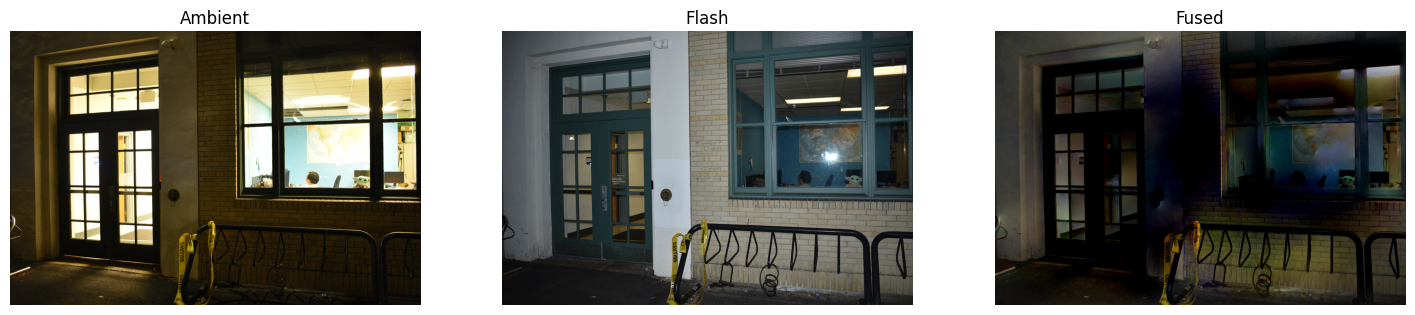

In [145]:
plot_3fig(Aimg, Flash_img, AFAvg_boundary, name='Mine_q22_fused_averageboundary.png', t1='Ambient', t2='Flash', t3='Fused')
# plt.imshow(AFAvg_boundary, cmap='gray')
# plt.savefig('q3_1.png')

In [144]:
Aimg.shape

(4000, 6000, 3)

Checking for correctness of padding in laplacian and gradient filters 

In [43]:
grad = gradient(Aimg[:, :, 0])
div = divergence(grad)
lap = laplacian(Aimg[:, :, 0])

(638, 905)
638 905
(638, 905) (3, 3)


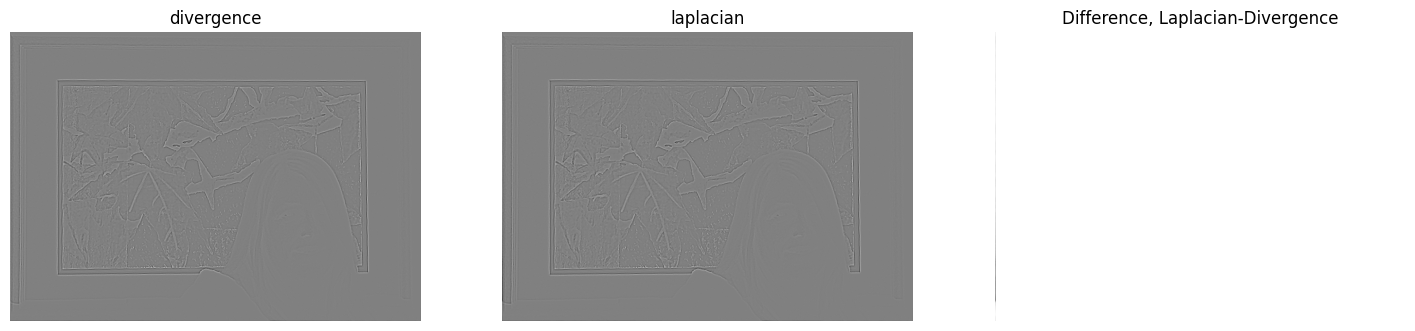

In [46]:
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(div, cmap='gray')
plt.title('divergence')
plt.axis('off')
fig.add_subplot(1, 3, 2)
plt.imshow(lap, cmap='gray')
plt.title('laplacian')
plt.axis('off')
fig.add_subplot(1, 3, 3)
plt.imshow(lap-div, cmap='gray')
plt.title('Difference, Laplacian-Divergence')
plt.axis('off')
plt.savefig('check_div_laplacian', bbox_inches='tight')
plt.show()
# diff = lap - div
# plt.imshow(diff, cmap='gray')
# plt.axis('off')

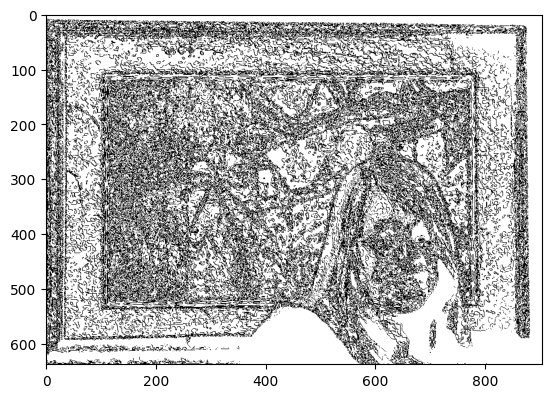

In [45]:
diff = div == lap
plt.imshow(diff, cmap='gray')